In [1]:
# # Cài đặt thư viện transformers và torch nếu chưa có
# !pip install transformers torch

In [2]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {"not", "never", "no", "very", "too", "so", "extremely", "really"}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Đọc dữ liệu từ file JSON
def load_data(file_path, label):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    texts = [entry['text'] for entry in data]
    labels = [label] * len(texts)
    return texts, labels

# Load dữ liệu positive, negative và neutral
positive_texts, positive_labels = load_data('positive_sentiment_data.json', 'positive')
negative_texts, negative_labels = load_data('negative_sentiment_data.json', 'negative')
neutral_texts, neutral_labels = load_data('neutral_sentiment_data.json', 'neutral')

# Gộp dữ liệu
texts = positive_texts + negative_texts + neutral_texts
labels = positive_labels + negative_labels + neutral_labels

# Tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower()  # Chuyển thành chữ thường
    text = re.sub(r'[\n\r]+', ' ', text)  # Xóa ký tự xuống dòng
    text = re.sub(r'\s+', ' ', text).strip()  # Chuẩn hóa khoảng trắng
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# In ví dụ trước và sau khi tiền xử lý
sample_text = texts[0]
print(f"\nVí dụ tiền xử lý văn bản:")
print(f"  - Trước: {sample_text}")
print(f"  - Sau: {preprocess_text(sample_text)}")

texts = [preprocess_text(text) for text in texts]


Ví dụ tiền xử lý văn bản:
  - Trước: Rated 5 stars by our customers, our online store offers the best deals and customer support for all your shopping needs!
A memorable encounter can be described as a time when something exceptional occurs that leaves a lasting impression on an individual's life. This could include moments such as meeting new people, experiencing novel sensations or acquiring products or services of superior quality. In this case, my great experience with the product or service was one that I cannot help but rave about to anyone who will listen – and many who don’t!
Our online store is a paradise for shoppers who are in search of incredible deals on an array of items ranging from clothing and electronics to furniture and kitchenware. From our wide range of products, it's clear to see that we value quality over quantity, ensuring every item available in our store meets the highest standards before being offered up for sale at prices so low they're practically laughabl

In [4]:
# Chia tập dữ liệu train và test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Biểu diễn văn bản - Bag of Words (BoW) và TF-IDF
vectorizer_bow = CountVectorizer()
vectorizer_tfidf = TfidfVectorizer()

X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [5]:
# Khởi tạo mô hình
models = [
    (MultinomialNB(), "Naive Bayes"),
    (LogisticRegression(max_iter=1000, C=0.1), "Logistic Regression"),
    (RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=5, random_state=42), "RandomForest")
]

# Hàm train và đánh giá mô hình
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'\n=== {model_name} ===')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))

# Huấn luyện và đánh giá mô hình với BoW
print("\n========== Using Bag of Words (BoW) ==========")
for model, name in models:
    train_and_evaluate(model, X_train_bow, X_test_bow, y_train, y_test, name)

# Huấn luyện và đánh giá mô hình với TF-IDF
print("\n========== Using TF-IDF ==========")
for model, name in models:
    train_and_evaluate(model, X_train_tfidf, X_test_tfidf, y_train, y_test, name)


========== Using Bag of Words (BoW) ==========

=== Naive Bayes ===
Accuracy: 0.9379
              precision    recall  f1-score   support

    negative       0.97      0.98      0.97       198
     neutral       0.92      0.93      0.92       183
    positive       0.93      0.90      0.92       215

    accuracy                           0.94       596
   macro avg       0.94      0.94      0.94       596
weighted avg       0.94      0.94      0.94       596


=== Logistic Regression ===
Accuracy: 0.9832
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99       198
     neutral       0.98      0.97      0.98       183
    positive       0.98      0.98      0.98       215

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596


=== RandomForest ===
Accuracy: 0.9396
              precision    recall  f1-score   support

    negative

In [6]:
# Chọn mô hình thử nghiệm
use_tfidf = False  # Đổi thành False nếu muốn dùng BoW

model = models[0][0]
X_train_vec = X_train_tfidf if use_tfidf else X_train_bow
X_test_vec = X_test_tfidf if use_tfidf else X_test_bow
vectorizer = vectorizer_tfidf if use_tfidf else vectorizer_bow

model.fit(X_train_vec, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test_vec)
print("\n=== Model Evaluation ===")
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

# Hàm dự đoán văn bản mới
def predict_sentiment(text, model, vectorizer):
    text_processed = preprocess_text(text)
    text_vectorized = vectorizer.transform([text_processed])
    prediction = model.predict(text_vectorized)[0]
    return prediction

# Dự đoán thử
positive_sentences = [
    "The customer service was excellent! The staff was very friendly and knowledgeable.",
    "I absolutely love this smartwatch! The battery lasts incredibly long, and the design is stylish.",
    "This hotel provided an amazing ocean view! The rooms were spotless, and breakfast was fantastic.",
    "Fantastic book! The unexpected plot twists kept me engaged, and the characters were well-developed.",
]

negative_sentences = [
    "The food arrived after an hour, completely cold and tasteless. A truly disappointing experience.",
    "The shoes fell apart in just a week. Poor quality, not worth buying.",
    "I waited 30 minutes in line just to hear that they were out of stock. Absolutely frustrating!",
    "This laptop constantly overheats and crashes. I really regret buying it.",
]

neutral_sentences = [
    "The phone has a 6.5-inch screen, 128GB storage, and a dual-camera setup.",
    "The book contains 300 pages, covering multiple psychology topics.",
    "The restaurant is located downtown and serves a combination of Italian and French dishes.",
    "The new software update provides a redesigned interface and more customization options.",
]

# # Dữ liệu test với văn bản dài hơn
# positive_sentences = [
#     "I had an absolutely wonderful experience at this hotel. The staff were incredibly welcoming, the rooms were spotless, and the ocean view was breathtaking. The complimentary breakfast had a wide variety of fresh options, and I loved the overall atmosphere. I would definitely come back again!",
#     "This new smartphone exceeded my expectations. The battery life is outstanding, lasting almost two full days on a single charge. The camera captures stunning photos even in low light, and the interface is smooth and intuitive. A fantastic purchase that I highly recommend!",
#     "I thoroughly enjoyed this book. The characters were well-developed, and the storyline kept me engaged from start to finish. The plot twists were unexpected yet satisfying, and I couldn't put the book down. Truly a masterpiece!"
# ]

# negative_sentences = [
#     "I was extremely disappointed with the service at this restaurant. We waited over an hour for our food, and when it finally arrived, it was cold and completely tasteless. The waiter was rude and unhelpful, and the overall experience was frustrating. I will not be returning here again!",
#     "This laptop is an absolute disaster. It constantly crashes, overheats, and takes forever to load even basic applications. The battery drains ridiculously fast, and the build quality feels cheap and flimsy. I deeply regret this purchase.",
#     "The airline experience was terrible. The flight was delayed multiple times without any clear explanation, the staff were unprofessional, and the seats were incredibly uncomfortable. To make things worse, my luggage was lost, and customer service was unresponsive. A complete nightmare!"
# ]

# neutral_sentences = [
#     "The latest software update introduces a redesigned user interface along with several performance improvements. It also includes security patches and bug fixes that address previous system vulnerabilities.",
#     "This documentary provides an in-depth look into the history of space exploration, covering significant milestones from the first satellite launch to modern-day Mars missions. It presents factual information without personal opinions or emotional bias.",
#     "The specifications of this laptop include a 15.6-inch display, an Intel Core i7 processor, 16GB of RAM, and a 512GB SSD. It runs on Windows 11 and supports the latest connectivity options, including Wi-Fi 6 and Bluetooth 5.0."
# ]

test_sentences = ["There is a very good meal but I don't like this restaurant"] + positive_sentences + negative_sentences + neutral_sentences

for sentence in test_sentences:
    predicted_label = predict_sentiment(sentence, model, vectorizer)
    print(f"Sentence: {sentence}\nPredicted Sentiment: {predicted_label}\n")



=== Model Evaluation ===
Accuracy: 0.9379
              precision    recall  f1-score   support

    negative       0.97      0.98      0.97       198
     neutral       0.92      0.93      0.92       183
    positive       0.93      0.90      0.92       215

    accuracy                           0.94       596
   macro avg       0.94      0.94      0.94       596
weighted avg       0.94      0.94      0.94       596

Sentence: There is a very good meal but I don't like this restaurant
Predicted Sentiment: negative

Sentence: The customer service was excellent! The staff was very friendly and knowledgeable.
Predicted Sentiment: positive

Sentence: I absolutely love this smartwatch! The battery lasts incredibly long, and the design is stylish.
Predicted Sentiment: positive

Sentence: This hotel provided an amazing ocean view! The rooms were spotless, and breakfast was fantastic.
Predicted Sentiment: positive

Sentence: Fantastic book! The unexpected plot twists kept me engaged, and th


========== Checking Overfitting with BoW ==========

=== Naive Bayes ===
Train Accuracy: 0.9693
Test Accuracy: 0.9379
Gap (Train - Test): 0.0314

=== Logistic Regression ===
Train Accuracy: 0.9996
Test Accuracy: 0.9832
Gap (Train - Test): 0.0164

=== RandomForest ===
Train Accuracy: 0.9634
Test Accuracy: 0.9396
Gap (Train - Test): 0.0238

========== Checking Overfitting with TF-IDF ==========

=== Naive Bayes ===
Train Accuracy: 0.9592
Test Accuracy: 0.9211
Gap (Train - Test): 0.0381

=== Logistic Regression ===
Train Accuracy: 0.9744
Test Accuracy: 0.9547
Gap (Train - Test): 0.0197

=== RandomForest ===
Train Accuracy: 0.9542
Test Accuracy: 0.9262
Gap (Train - Test): 0.0280


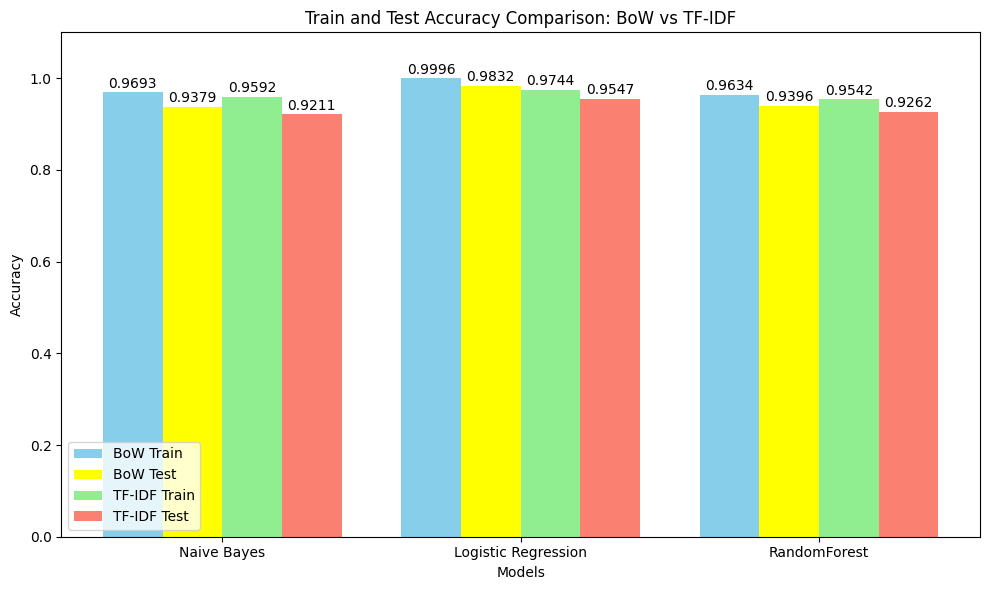

In [7]:
# Hàm kiểm tra overfitting và thu thập accuracy
def check_overfitting(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\n=== {model_name} ===')
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Gap (Train - Test): {train_acc - test_acc:.4f}')
    return train_acc, test_acc

# Thu thập dữ liệu
bow_train_acc = []
bow_test_acc = []
tfidf_train_acc = []
tfidf_test_acc = []
model_names = []

print("\n========== Checking Overfitting with BoW ==========")
for model, name in models:
    train_acc, test_acc = check_overfitting(model, X_train_bow, X_test_bow, y_train, y_test, name)
    bow_train_acc.append(train_acc)
    bow_test_acc.append(test_acc)
    model_names.append(name)

print("\n========== Checking Overfitting with TF-IDF ==========")
for model, name in models:
    train_acc, test_acc = check_overfitting(model, X_train_tfidf, X_test_tfidf, y_train, y_test, name)
    tfidf_train_acc.append(train_acc)
    tfidf_test_acc.append(test_acc)

# Vẽ biểu đồ
x = np.arange(len(model_names))  # Vị trí: 0, 1, 2
width = 0.2  # Độ rộng cột

fig, ax = plt.subplots(figsize=(10, 6))

# Cột cho BoW
ax.bar(x - width*1.5, bow_train_acc, width, label='BoW Train', color='skyblue')
ax.bar(x - width/2, bow_test_acc, width, label='BoW Test', color='yellow')

# Cột cho TF-IDF
ax.bar(x + width/2, tfidf_train_acc, width, label='TF-IDF Train', color='lightgreen')
ax.bar(x + width*1.5, tfidf_test_acc, width, label='TF-IDF Test', color='salmon')

# Định dạng biểu đồ
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracy Comparison: BoW vs TF-IDF')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.set_ylim(0, 1.1)

# Hiển thị giá trị trên cột
for i, v in enumerate(bow_train_acc):
    ax.text(i - width*1.5, v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(bow_test_acc):
    ax.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(tfidf_train_acc):
    ax.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(tfidf_test_acc):
    ax.text(i + width*1.5, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Thử nghiệm với BERT Fine-tuning

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# 1. Chuẩn bị dữ liệu cho BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2} # Map nhãn sang số

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label_str = self.labels[item]
        label = self.label_map[label_str]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Khởi tạo Tokenizer và Dataset
print("\n=== Preparing Data for BERT ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

# 3. Khởi tạo Model
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# 4. Cấu hình Training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    no_cuda=not torch.cuda.is_available()
)

# 5. Khởi tạo Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 6. Huấn luyện
trainer.train()


=== Preparing Data for BERT ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/894 [00:00<?, ?it/s]

{'loss': 0.4785, 'grad_norm': 0.2746116816997528, 'learning_rate': 4.490950226244344e-05, 'epoch': 0.34}
{'loss': 0.184, 'grad_norm': 0.32970449328422546, 'learning_rate': 3.925339366515837e-05, 'epoch': 0.67}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.20702172815799713, 'eval_accuracy': 0.9580536912751678, 'eval_runtime': 5.7576, 'eval_samples_per_second': 103.515, 'eval_steps_per_second': 6.6, 'epoch': 1.0}
{'loss': 0.2086, 'grad_norm': 94.80311584472656, 'learning_rate': 3.359728506787331e-05, 'epoch': 1.01}
{'loss': 0.0584, 'grad_norm': 0.022724755108356476, 'learning_rate': 2.7941176470588236e-05, 'epoch': 1.34}
{'loss': 0.0644, 'grad_norm': 0.029694607481360435, 'learning_rate': 2.228506787330317e-05, 'epoch': 1.68}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.09994613379240036, 'eval_accuracy': 0.9798657718120806, 'eval_runtime': 5.379, 'eval_samples_per_second': 110.801, 'eval_steps_per_second': 7.064, 'epoch': 2.0}
{'loss': 0.0743, 'grad_norm': 0.176565021276474, 'learning_rate': 1.66289592760181e-05, 'epoch': 2.01}
{'loss': 0.0178, 'grad_norm': 0.026113038882613182, 'learning_rate': 1.0972850678733031e-05, 'epoch': 2.35}
{'loss': 0.0209, 'grad_norm': 0.008340193890035152, 'learning_rate': 5.316742081447964e-06, 'epoch': 2.68}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.08449115604162216, 'eval_accuracy': 0.9848993288590604, 'eval_runtime': 5.7145, 'eval_samples_per_second': 104.297, 'eval_steps_per_second': 6.65, 'epoch': 3.0}
{'train_runtime': 257.2805, 'train_samples_per_second': 27.752, 'train_steps_per_second': 3.475, 'train_loss': 0.12385847677020419, 'epoch': 3.0}


TrainOutput(global_step=894, training_loss=0.12385847677020419, metrics={'train_runtime': 257.2805, 'train_samples_per_second': 27.752, 'train_steps_per_second': 3.475, 'total_flos': 469657450644480.0, 'train_loss': 0.12385847677020419, 'epoch': 3.0})

In [9]:
# Đánh giá mô hình BERT
print("\n=== BERT Evaluation ===")
eval_result = trainer.evaluate()
print(f"BERT Accuracy: {eval_result['eval_accuracy']:.4f}")

# Hàm dự đoán với BERT
def predict_sentiment_bert(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        model.to('cuda')
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = outputs.logits.softmax(dim=1)
    pred_label_idx = probs.argmax().item()
    label_map_inv = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return label_map_inv[pred_label_idx]

# Dự đoán
print("\n=== BERT Predictions on Test Sentences ===")
for sentence in test_sentences:
    pred = predict_sentiment_bert(sentence, model_bert, tokenizer)
    print(f"Sentence: {sentence}\nPredicted (BERT): {pred}\n")


=== BERT Evaluation ===


  0%|          | 0/38 [00:00<?, ?it/s]

BERT Accuracy: 0.9849

=== BERT Predictions on Test Sentences ===
Sentence: There is a very good meal but I don't like this restaurant
Predicted (BERT): positive

Sentence: The customer service was excellent! The staff was very friendly and knowledgeable.
Predicted (BERT): positive

Sentence: I absolutely love this smartwatch! The battery lasts incredibly long, and the design is stylish.
Predicted (BERT): positive

Sentence: This hotel provided an amazing ocean view! The rooms were spotless, and breakfast was fantastic.
Predicted (BERT): positive

Sentence: Fantastic book! The unexpected plot twists kept me engaged, and the characters were well-developed.
Predicted (BERT): positive

Sentence: The food arrived after an hour, completely cold and tasteless. A truly disappointing experience.
Predicted (BERT): negative

Sentence: The shoes fell apart in just a week. Poor quality, not worth buying.
Predicted (BERT): negative

Sentence: I waited 30 minutes in line just to hear that they were 